# Exploratory Data Analysis

## Environment and Dataset Setup

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
# import data from csv
df = pd.read_csv('../data/homes.csv', parse_dates=['Date'])
df.head()

,Status,MLS#,Property Type,County,Style,Year Built,Master on Main,Rooms,Kitchen,Interior,...,Other,Sprinkler,Veranda,Water Feature,City,State,Zip,Latitude,Longitude,Result_Addy
0,New,20034789,Rental,Fulton,Other Traditional,2007.0,No,Other,NaN,Double Vanity Soaking Tub Other Separate Showe...,...,0,0,0,0,Fairburn,GA,30213,-84.61930,33.623745,"4903 ESTONIAN DR, FAIRBURN, GA, 30213"
1,New,20034789,Rental,Fulton,Other Traditional,2007.0,No,Other,NaN,Double Vanity Soaking Tub Other Separate Showe...,...,0,0,0,0,Fairburn,GA,30213,-84.61930,33.623745,"4903 ESTONIAN DR, FAIRBURN, GA, 30213"
2,New,20034793,Rental,Henry,Traditional,2018.0,No,Other,NaN,Soaking Tub Separate Shower Walk-In Closet(s),...,0,0,0,0,Hampton,GA,30228,-84.24665,33.447810,"608 SEDONA LOOP, HAMPTON, GA, 30228"
3,New,20034793,Rental,Henry,Traditional,2018.0,No,Other,NaN,Soaking Tub Separate Shower Walk-In Closet(s),...,0,0,0,0,Hampton,GA,30228,-84.24665,33.447810,"608 SEDONA LOOP, HAMPTON, GA, 30228"
4,New,20036362,Rental,Clayton,Traditional,2020.0,No,Other,NaN,Other,...,0,0,0,0,Hampton,GA,30228,NaN,NaN,NaN


In [3]:
# use only most recent row for duplicates (if MLS# duplicated, use most recent entry)
rdf = df.sort_values('Date', ascending=False) # most recent come first
rdf.drop_duplicates('MLS#', keep='first', inplace=True, ignore_index=True)

In [4]:
# if price > 100000, then drop entry since property is not a rental
rdf.drop(rdf[rdf['Price'] > 100_000].index, axis=0, inplace=True)

In [5]:
# dimensionality of dataset
print(f'{len(rdf.columns)} columns, {len(rdf)} rows')

# how many non-NaN datapoints in each column
notna_cols = rdf.notna().sum(axis=0)
#print(notna_cols)

# how many non-NaN datapoints in each row
notna_rows = rdf.notna().sum(axis=1)
#print(notna_rows)

# how many full rows and columns (no NaNs)?
print(f'{notna_rows.value_counts()[len(rdf.columns)]} full rows')
print(f'{notna_cols.value_counts()[len(rdf)]} full columns')
print()
print(notna_rows.value_counts()) #outputs in format (num values | num rows)

50 columns, 6990 rows
1425 full rows
35 full columns

48    1646
50    1425
49    1356
47    1220
46     808
45     300
44     133
43      76
42      14
41      10
40       2
dtype: int64


## Initial Exploration

In [6]:
# view columns of dataset and their unique values
uniques = pd.Series(dtype=object)
for col in rdf.columns:
    uniques[col] = list(rdf[col].unique()) + ['-']*(len(rdf) - len(rdf[col].unique()))

# view number of unique values for each column
num_uniques = pd.Series(dtype=int)
for col in rdf.columns:
    num_uniques[col] = [len(rdf[col].unique())]

# view value distributions per column (will repeat after one-hot encoding)
uniques_dist = pd.DataFrame()
for col in rdf.columns:
    counts = rdf[col].value_counts(normalize=True)
    uniques_dist[col] =  list(counts) + [0 for i in range(len(rdf) - len(counts))]

## Data Cleaning and Preprocessing

In [7]:
# useful functions for keyword splitting

def flatten(lst): # flatten list of lists into single 1D list
    return [item for sub in lst for item in sub]

def remove(lst, val): # remove all instances of val from lst
    return list(filter(lambda x: x != val, lst))

def check_complete(col, keywords, df): # for manual extraction, check if all keywords listed (didn't miss any)
    res = ''
    for s in df[col].fillna(' '):
        op = s
        for kw in keywords:
          op = op.replace(kw, '')
        res += op
    if (checkstr := res.replace(',', '').strip()) ==  '': # if anything other than '' and ',' in output, a keyword was missed
        return True
    else:
        return checkstr

In [8]:
# convert 'Year Built' to 'Age'
rdf['Age'] = pd.Series([2022-y for y in rdf['Year Built']])

# simplify Water column
rdf['Water'] = rdf['Water'].replace(['Shared Well', 'Shared Well Well', 'Public Well'], 'Shared').replace(['Well', 'Private Well'], 'Private')
# rdf['Water'].value_counts(normalize=True)

# simplify Basement_Entry column
rdf['Basement_Entry'] = rdf['Basement_Entry'].replace('Both', 'Interior Exterior')

In [9]:
# replace Zipcode with median income, total households
# isolate relevant data from incomes dataset
income_df = pd.read_csv('../data/incomes.csv').set_index('Label (Grouping)').T.loc[:, ['Total', 'Median income (dollars)']]
income_df.rename(columns={'Total': 'Households', 'Median income (dollars)': 'Median Income'}, inplace=True)

for (row_index, row_data) in income_df.iterrows():
    if '!!Households!!' not in row_index:
        income_df.drop(row_index, axis=0, inplace=True)
    else:
        income_df.rename(index={row_index: row_index[6:11]}, inplace=True)

# some zipcodes have no associated data in income_df; check if any of these zipcodes are in our dataset
df_zips = rdf['Zipcode'].unique()
empty_zips = [z for (z, data) in income_df.iterrows() if data['Median Income'] == '-']
print(f'{len(set(df_zips) & set(empty_zips))} overlap')

0 overlap


In [10]:
# since there is no overlap, we are clear to drop these zipcodes from the df and convert the rest of the df into numeric values
for (row_index, row_data) in income_df.iterrows():
    if row_index in empty_zips:
        income_df.drop(row_index, axis=0, inplace=True)
    else:
        income_df.loc[row_index] = pd.to_numeric(row_data.str.replace(',', ''))

income_df.index = income_df.index.astype(np.int64, copy=False) # convert index to int64 type
income_df.drop(income_df[income_df.index > 30620].index, axis=0, inplace=True) # nothing above 30620 in rdf so drop all data for zip codes >30620

In [11]:
# add Households and Median Income to rdf based on zipcode
income_df['Zipcode'] = income_df.index
rdf = pd.merge(rdf, income_df)

In [12]:
# drop all columns from dataframe that are clearly inconsequential or covered by other columns
to_drop = ['MLS#', 'Status', 'County', 'Street_Addy', 'Description', 'Elementary School', 'Middle School', 'High School', 'Date',
'City', 'State', 'Zip', 'Latitude', 'Longitude', 'Result_Addy', 'Year Built', 'Zipcode']
rdf.drop(to_drop, axis=1, inplace=True)

In [13]:
# split the entries of categorical and description-based columns (categorical multi-select) into keywords and save in dictionary
# remove 'None' from each type list to avoid multicollinearity (dummy encoding)
# no need for others because an entry can have a 1 in multiple columns (e.g. both Interior and Exterior basement entry)
types = {}

# Water
water_types = ['Public', 'Private', 'Shared']
types['Water'] = water_types
# print(check_complete('Water', water_types, rdf))

# Style
style_types = ['Brick 4 Side', 'Brick 3 Side', 'Ranch', 'Traditional', 'European', 'Craftsman', 'Brick Front', 'Contemporary',
'Other', 'Bungalow/Cottage', 'Brick/Frame', 'A-frame', 'Cape Cod', 'Country/Rustic', 'Colonial', 'Victorian', 'Stone Frame',
'French Provincial', 'Cluster', 'Tudor', 'Modular Home', 'Mediterranean', 'Adirondack']
# print(check_complete('Style', style_types, rdf))
types['Style'] = style_types

# Rooms
room_types = ['Keeping', 'Game', 'Great', 'Sun', 'Library', 'Den', 'Other', 'Laundry', 'Foyer', 'Exercise', 
'Family', 'Loft', 'Media', 'Office', 'Bonus']
# room_types = list(set(flatten([remove(s.replace(',', '').split(' '), 'Room') for s in df['Rooms'].fillna(' ')])) - set([''])) # automated
# print(check_complete('Rooms', room_types, rdf))
types['Rooms'] = room_types

# Kitchen
kitchen_types = ['Breakfast Bar', 'Breakfast Area', 'Pantry', 'Solid Surface Counters', 
'Breakfast Room', 'Kitchen Island', 'Walk-in Pantry', 'Second Kitchen', 'Country Kitchen']
# print(check_complete('Kitchen', kitchen_types, rdf))
types['Kitchen'] = kitchen_types

# Interior
interior_types = ['Other', 'Master On Main Level', 'High Ceilings', 'Double Vanity', 'Beamed Ceilings', 
'Two Story', 'Foyer', 'Rear Stairs', 'Separate Shower', 'Walk-In Closet(s)', 'Whirlpool Bath', 'In-Law Floorplan',
'Tile Bath', 'Wine Cellar', 'Soaking Tub', 'Pulldown Attic Stairs', 'Roommate Plan', 'Vaulted Ceiling(s)', 
'Tray Ceiling(s)', 'Bookcases', 'Split Bedroom Plan', 'Central Vacuum', 'Wet Bar', 'Sauna', 'Attic Expandable', 'Split']
# print(check_complete('Interior', interior_types, rdf))
types['Interior'] = interior_types

# Heating
heating_types = ['Forced Air', 'Natural Gas', 'Central', 'Zoned', 'Propane', 'Other', 'Electric', 'Heat Pump', 'Hot Water', 
'Dual', 'Common', 'Baseboard', 'Floor Furnace', 'Wood', 'Oil', 'Steam']
# print(check_complete('Heating', heating_types, rdf))
types['Heating'] = heating_types

# Cooling
cooling_types = ['Ceiling Fan(s)', 'Central Air', 'Electric', 'Zoned', 'Other', 'Dual', 'Common', 'Heat Pump', 'Gas', 
'Attic Fan', 'Whole House Fan', 'Window Unit(s)']
# print(check_complete('Cooling', cooling_types, rdf))
types['Cooling'] = cooling_types

# Construction
construction_types = ['Stucco', 'Stone', 'Brick', 'Wood Siding', 'Vinyl Siding', 'Other', 'Concrete', 'Rough-Sawn Lumber',
'Aluminum Siding', 'Press Board', 'Steel Siding', 'Block', 'Synthetic', 'Log']
# print(check_complete('Construction', construction_types, rdf))
types['Construction'] = construction_types

# Roof
roof_types = ['Composition', 'Metal', 'Other', 'Concrete', 'Tile', 'Tar/Gravel', 'Slate', 'Wood', 'Tin']
# print(check_complete('Roof', roof_types, rdf))
types['Roof'] = roof_types

# Parking
parking_types = ['Garage Door Opener', 'Carport', 'Assigned', 'Kitchen Level', 'Off Street', 'Parking Pad',
'Side/Rear Entrance', 'Detached', 'Attached', 'Over 1 Space per Unit', 'Basement', 'RV/Boat Parking', 'Guest', 'Storage', 
'Parking Shed', 'Garage']
# print(check_complete('Parking', parking_types, rdf))
types['Parking'] = parking_types

# Amenities
amenities_types = ['Pool', 'Tennis Court(s)', 'Clubhouse', 'Gated', 'Golf', 'Park', 'Fitness Center', 'Playground', 'Street Lights',
'Walk To Shopping', 'Sidewalks', 'Walk To Schools', 'Swim Team', 'Tennis Team', 'Lake', 'Walk To Public Transit', 'Guest Lodging',
'Airport/Runway', 'Stable(s)', 'Shared Dock', 'Racquetball', 'Marina', 'Retirement Community', 'Boat/Camper/Van Prkg']
# print(check_complete('Amenities', amenities_types, rdf))
types['Amenities'] = amenities_types

# Lot
lot_types = ['City Lot', 'Private', 'Level', 'Cul-De-Sac', 'Sloped', 'Open Lot', 'Corner Lot', 'Other', 'Zero Lot Line',
'Waterfall', 'Greenbelt', 'Steep Slope', 'Pasture']
# print(check_complete('Lot', lot_types, rdf))
types['Lot'] = lot_types

# Basement_Entry
entry_types = ['Interior', 'Exterior']
# print(check_complete('Basement_Entry', entry_types, rdf))
types['Basement_Entry'] = entry_types

In [14]:
# replace those columns with new binary ones based on keywords (one-hot encoding)
def add_one_hots(type_dict, df):
    edf = df.copy(deep=True) # new, expanded dataframe
    for og_col in type_dict.keys():
        for col in type_dict[og_col]:
            # print(col) # for debugging
            # create col in dataframe
            col_values = []
            # values in col = 1 if col name in row's og_col entry else 0
            for index, row in df.iterrows():
                row_str = str(row[og_col])
                if col in row_str:
                    code = 1
                else:
                    code = 0
                col_values.append(code)
            edf[f'{og_col}: {col}'] = pd.Series(col_values)
        edf = edf.drop(og_col, axis=1)
    return edf

edf = add_one_hots(types, rdf)

In [15]:
# convert Master on Main (0-No, 1-Yes) and Property Type (0-Residential Lease, 1-Rental) into binary numerical values
# convert Basement_Finished into nominal value (higher number -> more finished, unknown = none or crawl, partial finished = unfinished)
def to_nums(col):
    if col.name in ('Master on Main', 'Property Type'):
        return pd.Series([1 if v in ('Yes', 'Rental') else 0 for v in col])
    elif col.name == 'Basement_Finished':
        return pd.Series([0 if v in ('Unknown', 'None or Crawl') else 0.5 if v in ('Partial Finished', 'Unfinished') else 1 for v in col])
    else:
        return col

ndf = edf.apply(to_nums) # numerical dataframe

## Correlational Analysis

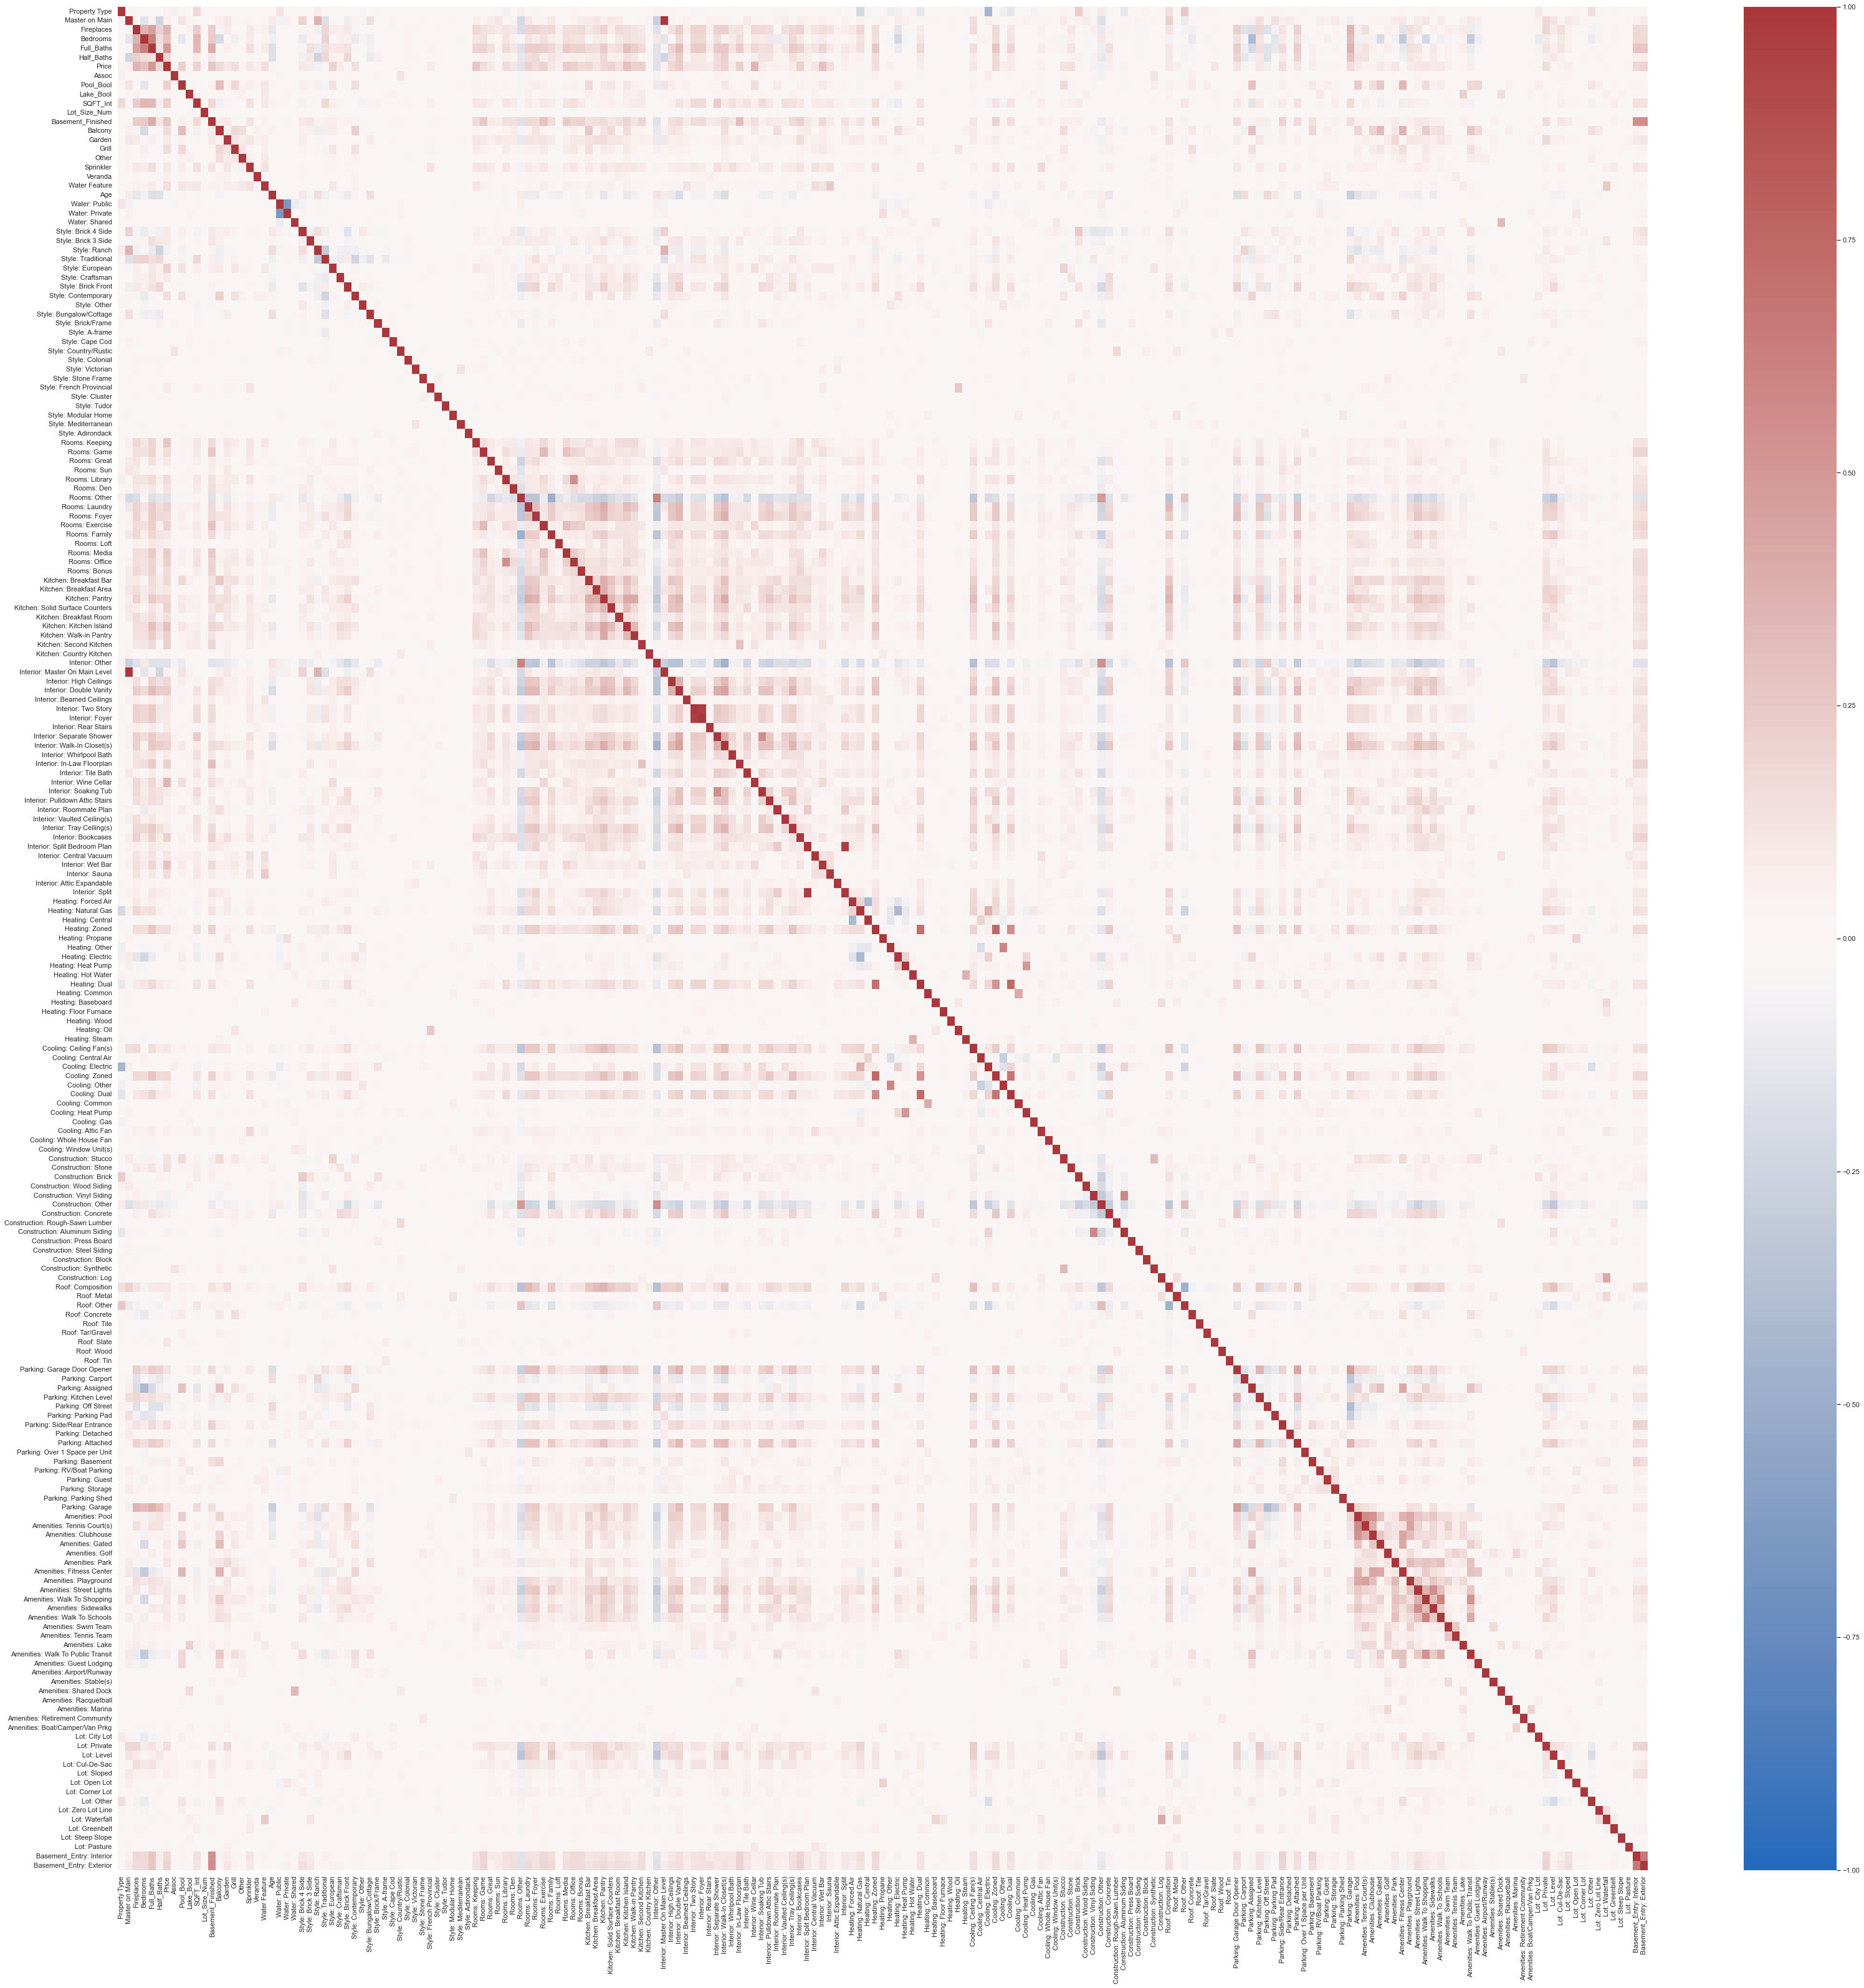

In [19]:
# correlation heatmap for all columns
corr = ndf.corr()
fig1 = plt.figure(figsize=(55,55))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, cmap='vlag')
plt.savefig('correlation.png')

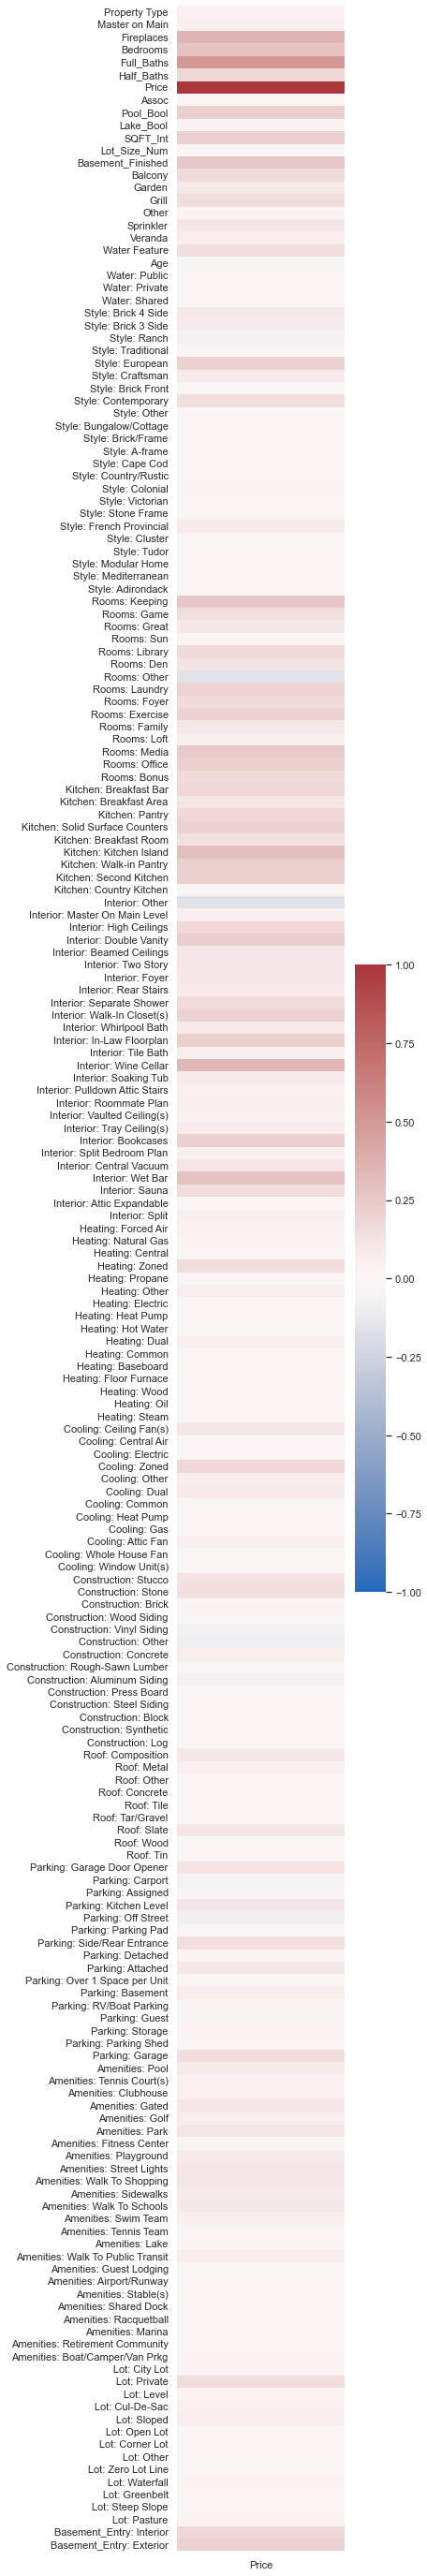

In [20]:
# correlation heatmap with focus on price
price_corr = pd.DataFrame(corr.loc['Price'])
fig2 = plt.figure(figsize=(4, 50))
price_heatmap = sns.heatmap(price_corr, vmin=-1, vmax=1, cmap='vlag')
plt.savefig('price_correlation.png')

In [18]:
# descriptive stats
ndf_descr = ndf.describe()